## Try: Replicate (much of) a Publication With PalmettoBUG

Paper: https://doi.org/10.1016/j.cmet.2018.11.014 
("A Map of Human Type 1 Diabetes Progression by Imaging Mass Cytometry". Damond N, Engler S, Zanotelli VRT, Schapiro D, Wasserfall CH, Kusmartseva I, Nick HS, Thorel F, Herrera PL, Atkinson MA and Bodenmiller B. Cell Metab. 2019 Mar 5;29(3):755-768.e5.)

Data source:

Download (images, panel, metadata -- likely update to version 2 before finalizing!): https://data.mendeley.com/datasets/cydmwsfztj/1
Download (masks): https://data.mendeley.com/datasets/cydmwsfztj/2

Data License: CC-BY 4.0 ( https://creativecommons.org/licenses/by/4.0/ ). Obviously tables / figures derived from this dataset using PalmettoBUG are modified from the original.

Notes:

    -- I am currently not working with the entirety of the dataset, only a subset.

    -- The example data's panel / metadata is not set up in a PalmettoBUG-friendly way, so I will need to set that up

    -- This publication does things that are difficult or at currently impossible in PalmettoBUG's GUI
    
        - ex: pseudo-time analysis (not possible in GUI), bounding boxes on individual pancreatic islets (difficult), cell densities
    
    -- I plan on doing this inside jupyter-lab notebooks, which will make some of the impossible steps possible and also precise replication of the steps that I take. However, I will also plan to test certain steps in the GUI to ensure that it is working as well

    -- I am not familiar with diabetes research, I will copy useful biological information from paper's text and methods here: 
           - Beta-cell markers = INS, PIN, IAPP, PTPRN ('markers' ), and PDX1, NKX6-1 ('transcription factors')

           - cell typing markers (use all mentioned in FlowSOM classification method):
                - islet vs. immune vs. exocrine vs. other --> CD99, SYP, AMY2A, KRT19, CD44, CD45, CDH, CD3, CD4, CD8, CD20, MPO, CD68, SMA

                - islet cell subtypes (alpha, beta, gamma, delta) --> INS, PIN, GCG, SST, PPY, PDX1, NKX6-1, IAPP, PCKS2, CD99, SYP

                - immune cells:
                     effector CD8 T cells: 'Tc' -- CD3, CD8, (CD45RA negative)
                     naive CD8 T cells: 'naive Tc' -- CD3, CD8, CD45RA
                     CD4 T cells: 'Th' -- CD3, CD4
                     B cells -- CD20
                     monocytes and macrophages: 'Mphi' -- CD45, CD68
                     neutrophils: 'Neutr' -- MPO
                     'other': CD45 or CD45RA but not in the categories above

                 - exocrine (acinar, ductal) --> KRT19, AMY2A, CD44, CDH

                 - other (endothelial, stroma, unknown) --> SMA, CD31, CD68, CDH

            - islet / blood vessel segmenation markers: SYP, CD99, CD31, CD45, AMY2A, KRT19, Iridum intercalator
                 

In [1]:
import os
import time
import warnings

import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
start_timer = time.time()

import palmettobug
print(time.time() - start_timer)  ## keep track of time after each major step

The PalmettoBUG package is copyrighted 2024-2025 by the Medical University of South Carolina and licensed under the GPL-3 license.
 It is free & open source software, can  be redistributed in compliance with the GPL3 license, and comes with absolutely no warranty.
 In python, use palmettobug.print_license() to see the license, or use palmettobug.print_3rd_party_license_info() to print information
 about the licenses and copyright of 3rd party software used in PalmettoBUG itself or in the creation of PalmettoBUG.
78.55034327507019


In [3]:
directory = "C:/Users/Default/Desktop/data/PBUG"  # where I placed the source images (in directory/raw), and the masks in (directory/masks/Masks),
                                                  # as well as the original panel and metadata

In [10]:
downloaded_panel = pd.read_csv(directory + "/original_panel.csv")
downloaded_panel                   ## notice the duplicate of Yb176 -- I not sure what this means. I will need to be careful to ensure that the 
                                   # channel order is the same and the channel labels are accurate (!!)

,MetalTag,Target,channel,clean_Target
0,In113,Histone H3,1,H3
1,In115,SMA,2,SMA
2,Pr141,insulin,3,INS
3,Nd142,CD38,4,CD38
4,Nd143,CD44,5,CD44
5,Nd144,Prohormone Convertase 2,6,PCSK2
6,Nd145,CD99,7,CD99
7,Nd146,CD68,8,CD68
8,Sm147,Myeloperoxidase MPO,9,MPO
9,Nd148,Glucose Transporter GLUT1,10,SLC2A1


In [27]:
downloaded_panel = downloaded_panel[downloaded_panel['clean_Target'] != 'cPARP1']   ## just drop one, ignore the other channel, too

pbug_panel = pd.DataFrame()
pbug_panel['channel'] = list(downloaded_panel['MetalTag'])
pbug_panel['name'] = list(downloaded_panel['clean_Target'])
pbug_panel['keep'] = 1
pbug_panel.loc[34,'keep'] = 0
pbug_panel['segmentation'] = ''    ## I plan to use the masks provided by the paper, not those generated in pbug / iSD by deepcell (or otherwise)
                                   ## so I can ignore this column entirely. Otherwise I'd set channels 0,36,37 to nuclei. I am less certain about the cytoplasmic channel(s)

In [30]:
## uncomment line below to examine panel

# pbug_panel

In [29]:
pbug_panel.to_csv(directory + "/panel.csv", index = False)

In [4]:
resolutions = [1.0, 1.0]
ImageAnalysis = palmettobug.imc_entrypoint(directory, resolutions = resolutions, from_mcds = False)
print(time.time() - start_timer)  ## keep track of time after each major step

78.66364598274231


In [32]:
# "convert" raw --> .ome.tiffs. Since were starting with tiffs, this is really just hot-pixel filtering
ImageAnalysis.raw_to_img(hpf = 0.85)

In [ ]:
print(time.time() - start_timer)  ## keep track of time after each major step

In [46]:
## do region measurements

analysis_folder = "analysis"
ImageAnalysis.directory_object.make_analysis_dirs(analysis_folder)
input_images = ImageAnalysis.directory_object.img_dir + "/img"
input_masks = ImageAnalysis.directory_object.masks_dir + "/Masks"
## masks provided in download do not match the PalmettoBUG / Steinbock convention of having identical names to the source files
for i in os.listdir(input_masks):
    current = f'{input_masks}/{i}'
    os.rename(current, current.replace("_masks",""))

ImageAnalysis.make_segmentation_measurements(input_images, input_masks, re_do = True)

C01_a0_full intensities csv has been written!
C02_a0_full intensities csv has been written!
C03_a0_full intensities csv has been written!
C04_a0_full intensities csv has been written!
C05_a0_full intensities csv has been written!
C06_a0_full intensities csv has been written!
C07_a0_full intensities csv has been written!
C08_a0_full intensities csv has been written!
C09_a0_full intensities csv has been written!
C10_a0_full intensities csv has been written!
C11_a0_full intensities csv has been written!
C12_a0_full intensities csv has been written!
C13_a0_full intensities csv has been written!
C14_a0_full intensities csv has been written!
C15_a0_full intensities csv has been written!
C16_a0_full intensities csv has been written!
C17_a0_full intensities csv has been written!
C18_a0_full intensities csv has been written!
C19_a0_full intensities csv has been written!
C20_a0_full intensities csv has been written!
C21_a0_full intensities csv has been written!
C22_a0_full intensities csv has be

In [ ]:
print(time.time() - start_timer)  ## keep track of time after each major step

In [56]:
panel, metadata, panel_path, metadata_path = ImageAnalysis.to_analysis()

Panel / Metadata could not be loaded from save (in Analyses directory) -- generating these from scratch


In [57]:
## read supplied metadata
downloaded_metadata = pd.read_csv(directory + "/Metadata.csv")

## reshape data from the paper to match PalmettoBUG expectations by mering with the auto-generated metdata file:
metadata['image'] = metadata['file_name'].str.replace("_a0_full.fcs","")
new_metadata = metadata.merge(downloaded_metadata, on = "image")
new_metadata['patient_id'] = new_metadata['part']
new_metadata['condition'] = new_metadata['stage']
metadata = new_metadata[['file_name','sample_id','patient_id','condition']]
metadata

,file_name,sample_id,patient_id,condition
0,C01_a0_full.fcs,0,Tail,Long-duration
1,C02_a0_full.fcs,1,Tail,Long-duration
2,C03_a0_full.fcs,2,Tail,Long-duration
3,C04_a0_full.fcs,3,Tail,Long-duration
4,C05_a0_full.fcs,4,Tail,Long-duration
...,...,...,...,...
422,W35_a0_full.fcs,422,Head,Long-duration
423,W36_a0_full.fcs,423,Head,Long-duration
424,W37_a0_full.fcs,424,Head,Long-duration
425,W38_a0_full.fcs,425,Head,Long-duration


In [77]:
# assign type / state / none to each marker in the panel
#display(panel)


# none channels are effectively ignored in most steps of PalmettoBUG analysis -- 
# 'none' for segmentation markers
none_channels = ['H3','Ir191','Ir193']  
# 'state' channels not used in the assignemnt of cell types (also these overlap with channels seemingly entirely ignored by the analysis
# I will likely similarly ignore these markers
state_channels = ['pRB','pH3','FOXP3','CD38','CA9','KI-67']

 ## type markers if mentioned in the paper as contributing to their classifier used to group cell types, or mentioned for pseudotime (SLC2A1)
type_channels = ['SMA','INS', 'CD99','CD3e','CD4','CD8a',
                 'SYP','AMY2A','KRT19','CD44','CD45','PPY',
                'CDH','CD20','MPO','CD68','SMA','PIN',
                'GCG','SST','PDX1','NKX6-1','IAPP','PCSK2',
                 'CD45RA','CD31','PTPRN','SLC2A1']  

panel.index = panel['antigen']
panel.loc[type_channels,'marker_class'] = 'type'

panel.loc[none_channels,'marker_class'] = 'none'
panel.loc[state_channels,'marker_class'] = 'state'
panel

,fcs_colname,antigen,marker_class,type
antigen,,,,
H3,H3,H3,none,none
SMA,SMA,SMA,type,type
INS,INS,INS,type,type
CD38,CD38,CD38,state,state
CD44,CD44,CD44,type,type
PCSK2,PCSK2,PCSK2,type,type
CD99,CD99,CD99,type,type
CD68,CD68,CD68,type,type
MPO,MPO,MPO,type,type


In [90]:
## be sure to export edited version of panel & metadata:
panel.to_csv(panel_path, index = False)
metadata.to_csv(metadata_path, index = False)

In [5]:
Analysis = palmettobug.Analysis()
Analysis.load_data(directory + "/Analyses/analysis/main")   # or: ImageAnalysis.directory_object.Analysis_internal_dir
print(time.time() - start_timer)  ## keep track of time after each major step

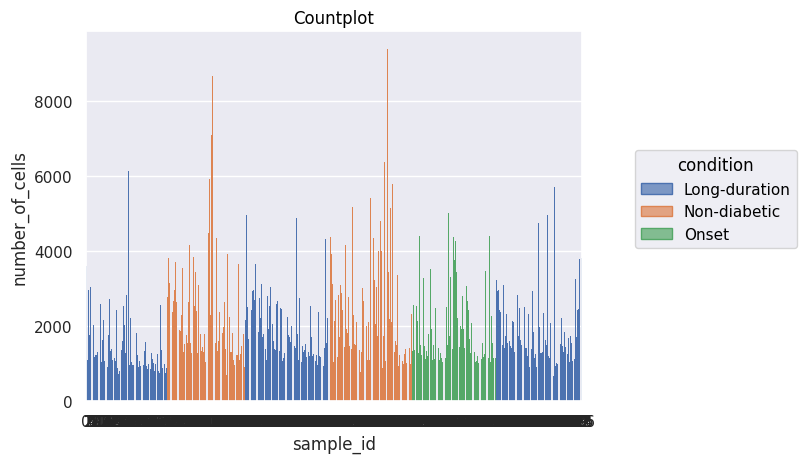

In [92]:
Analysis.plot_cell_counts()

In [6]:
Analysis.do_scaling('%quantile',99.9)

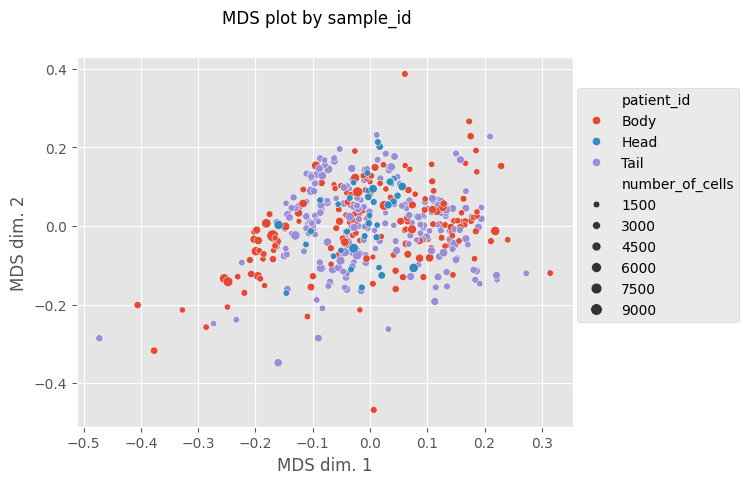

In [101]:
fig, mds_df = Analysis.plot_MDS(marker_class = 'type', color_by = 'patient_id')
fig

In [8]:
Analysis.do_flowsom(n_clusters = 20, seed = 1234)
print(time.time() - start_timer)  ## keep track of time after each major step

2025-06-17 16:48:37.927 | DEBUG    | flowsom.main:__init__:82 - Reading input.
2025-06-17 16:48:37.935 | DEBUG    | flowsom.main:__init__:84 - Fitting model: clustering and metaclustering.
2025-06-17 16:50:28.213 | DEBUG    | flowsom.main:__init__:86 - Updating derived values.


7968.198198318481


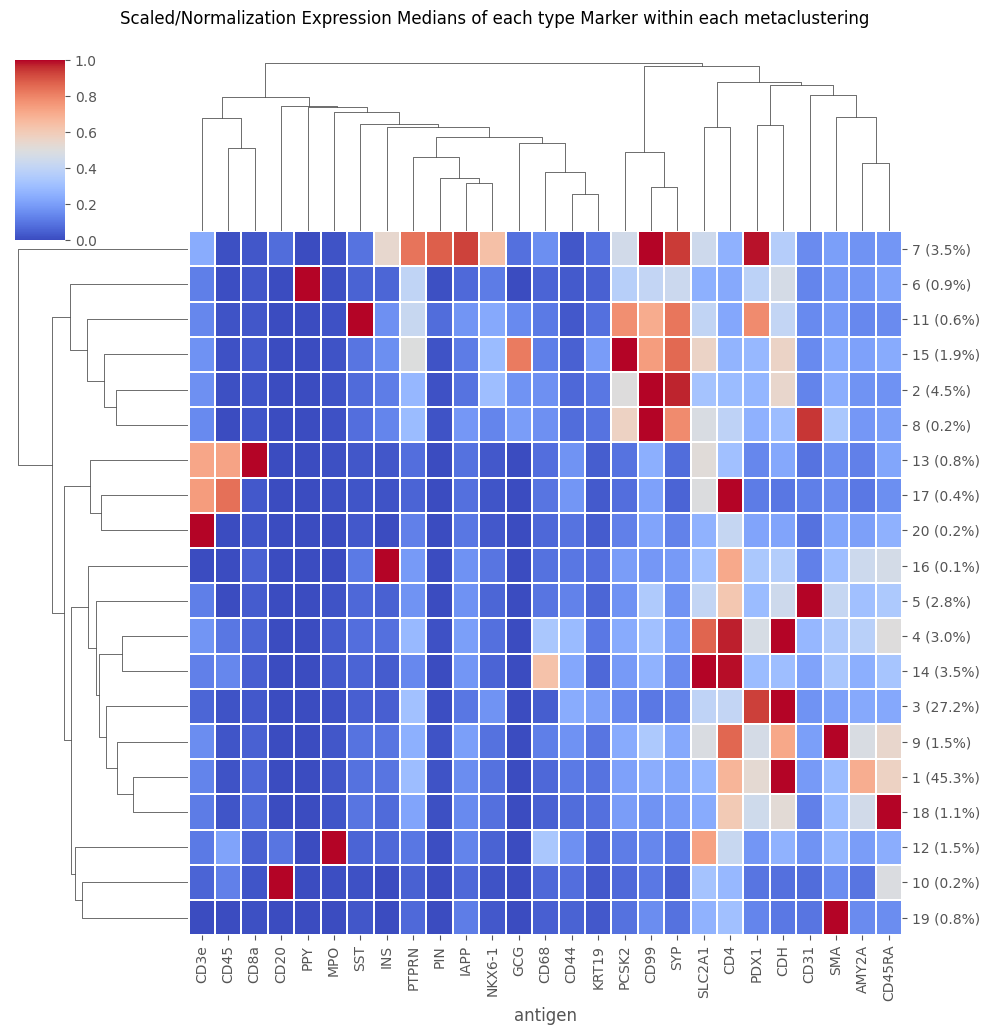

In [9]:
fig = Analysis.plot_medians_heatmap(marker_class = 'type', groupby = 'metaclustering')

In [ ]:
## now annotate data

C:\Users\benca\miniforge3\envs\main\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


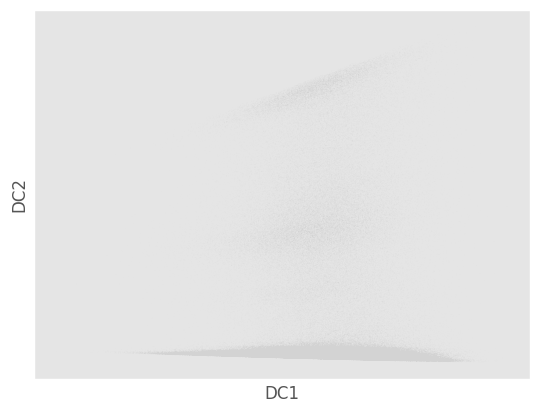

7824.565535545349


In [7]:
## test pseudotime -- will really want to run this on islet segmentations
sc.pp.neighbors(Analysis.data)
sc.tl.diffmap(Analysis.data)
sc.pl.diffmap(Analysis.data)
print(time.time() - start_timer)  ## keep track of time after each major step